# Natural Language Processing with AI/HUMAN essay

The primary objective of this project is to analyze docs to determine whether they come from humans or are generated by AI. Specifically, we aim to:

- Collect and preprocess a dataset of docs.
- Use the VADER (Valence Aware Dictionary for Sentiment Reasoning) sentiment analysis model to assess the sentiment of each doc.
- Fine-tune the VADER model to improve its accuracy in identifying AI docs.
- Evaluate the model’s performance using appropriate metrics.

Our objective was also to evaluate the performance of models that do not use deep learning techniques, also making a domain classification, building a new surrogate.

Evaluate the model’s performance using metrics such as accuracy, precision, recall, and F1 score. Our fine-tuned VADER model achieved an F1 score of 81% on the validation set.

Please note that the model parameters were determined using a wrapper method guided by the data itself. Specifically, we evaluated the model's performance as the parameters varied, selecting the combination that yielded the best results.

In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import words
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from nltk.stem import PorterStemmer, LancasterStemmer
import re
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import KFold
from itertools import product
from statistics import mean
import random

In [2]:
nltk.download([
    "names",
    "stopwords",
    "state_union",
    "twitter_samples",
    "movie_reviews",
    "averaged_perceptron_tagger",
    "vader_lexicon",
    "punkt",
    "gutenberg",
    'twitter_samples',
    'words',
    "punkt_tab"
])

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Unzipping corpora/state_union.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpor

True

Implementing all our functions.

In [3]:
def remove_stopwords(text):
    """
    Remove stopwords from the input text.

    Parameters:
    text (str): Input text from which stopwords will be removed.

    Returns:
    str: Text with stopwords removed.

    Example:
    >>> text = "This is an example sentence."
    >>> remove_stopwords(text)
    'example sentence.'
    """

    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_text = ' '.join([word for word in words if word.lower() not in stop_words])
    return filtered_text

In [4]:
def stem_text(text, stemmer_type=LancasterStemmer):
    """
    Apply stemming to the input text based on the specified stemmer type.

    Parameters:
    text (str): Input text to be stemmed.
    stemmer_type (type): Type of stemmer to use (e.g., PorterStemmer, LancasterStemmer == default).

    Returns:
    str: Stemmed text.

    Example:
    >>> text = "Running cats and dogs are running"
    >>> stem_text(text, PorterStemmer)
    'run cat and dog are run'
    """

    stemmer = stemmer_type()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

In [5]:
def get_frequences(text):
    """
    Calculate the frequencies of words in the input text.

    Parameters:
    text (str): Input text to analyze.

    Returns:
    dict: A dictionary where keys are words and values are their frequencies.

    Example:
    >>> text = "This is a sample text. Another sentence."
    >>> get_frequencies(text)
    {'sentence': 1, 'This': 1, 'is': 1, 'a': 1, 'sample': 1, 'text': 1, 'Another': 1, '.': 1}
    """

    words = word_tokenize(text)
    freq_dist = FreqDist(words)
    return dict(map(lambda x:(x[0], x[1]),freq_dist.most_common()))

In [6]:
def normalize_dict_values(input_dict):
    """
    Normalize the values of a dictionary to the range [0, 1].

    Parameters:
    input_dict (dict): Dictionary with numeric values to be normalized.

    Returns:
    dict: A dictionary with keys unchanged and values normalized to the range [0, 1].

    Example:
    >>> data = {'A': 10, 'B': 20, 'C': 30}
    >>> normalize_dict_values(data)
    {'A': 0.0, 'B': 0.5, 'C': 1.0}
    """

    values = list(input_dict.values())
    min_value = min(values)
    max_value = max(values)

    normalized_dict = {}
    for k, v in input_dict.items():
        normalized_value = (v - min_value) / (max_value - min_value)
        normalized_dict[k] = normalized_value

    return normalized_dict

In [7]:
def get_title(url):
    """
    Retrieve the title of a web page from the given URL.

    Parameters:
    url (str): The URL of the web page.

    Returns:
    str: The title of the web page, stripped of leading and trailing whitespace,
         or the original URL if the title retrieval fails.

    Example:
    >>> url = 'https://www.example.com'
    >>> get_title(url)
    'Example Domain'
    """

    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup.title.string.strip()
    except Exception as e:
        print(f"Failed to retrieve title for {url}: {e}")
        return url

In [8]:
def expand_url(short_url):
    """
    Expand a shortened URL to its original long URL.

    Parameters:
    short_url (str): The shortened URL to expand.

    Returns:
    str: The original long URL after following redirects, or the original short URL if expansion fails.

    Example:
    >>> short_url = 'https://bit.ly/3vDjmQW'
    >>> expand_url(short_url)
    'https://openai.com/'

    Notes:
    The function uses HTTP HEAD requests to follow redirects and resolve the original URL.
    """

    try:
        response = requests.head(short_url, allow_redirects=True)
        print(f"Link solved. From {short_url} to {response.url}")
        return response.url
    except requests.RequestException as e:
        print("Link not solved!")
        return short_url  # If there's an error, return the original short URL

In [9]:
def replace_shortened_urls(text):
    """
    Replace shortened URLs in the input text with their original long URLs.

    Parameters:
    text (str): The input text containing shortened URLs.

    Returns:
    str: Text with shortened URLs replaced by their original long URLs.

    Example:
    >>> text = "Check out http://t.co/abc123 for more information."
    >>> replace_shortened_urls(text)
    'Check out https://example.com/expanded for more information.'

    Notes:
    This function uses the expand_url function to resolve each shortened URL found in the text.
    """

    short_url_pattern = r'http://t\.co/\w+'
    short_urls = re.findall(short_url_pattern, text)
    for short_url in short_urls:
        expanded_url = expand_url(short_url)
        text = text.replace(short_url, expanded_url)
    return text

In [10]:
def filter_english_words(text):
    """
    Filter out non-English words from the input text.

    Parameters:
    text (str): The input text to filter.

    Returns:
    str: Text with only English words preserved.

    Example:
    >>> text = "He loves to read books and learn new languages."
    >>> filter_english_words(text)
    'He loves to read and learn new'

    Notes:
    This function uses NLTK's words corpus to determine if words in the text are English.
    """

    english_words = set(words.words())
    words_in_text = text.split()
    filtered_words = list(filter(lambda x: x.lower() in english_words, words_in_text))
    return ' '.join(filtered_words)

In [11]:
def plural_to_singular(text):
    """
    Convert plural nouns in the input text to their singular form.

    Parameters:
    text (str): The input text to convert.

    Returns:
    str: Text with plural nouns converted to singular form.

    Example:
    >>> text = "Apples are delicious. I like eating oranges and bananas."
    >>> plural_to_singular(text)
    'Apple is delicious. I like eating orange and banana.'
    """

    p = inflect.engine()
    words = text.split()
    singular_words = []

    for word in words:
        if p.singular_noun(word):
            singular_words.append(p.singular_noun(word))
        else:
            singular_words.append(word)

    return ' '.join(singular_words)

# Function `dictionary_update` for Fine-Tuning the VADER Model

The `dictionary_update` function calculates and updates word weights using the VADER model for tweets associated with AI and HUMAN text.

#### Description

This function computes word weights to enhance the VADER sentiment analysis model used for docs classification. The weights are updated based on word frequencies in negative and positive post, adjusted by `beta` and `alpha` respectively.

#### Weight Update Formula

The updated weight of a word `x` is calculated as:

$$
\text{new_weight}(x) = \text{frequency_AI_doc}(x) \times \beta - \text{frequency_of_HUMAN_doc}(x) \times \alpha
$$

- `alpha` and `beta` are weight multipliers for HUMAN and AI docs, respectively.

In [12]:
def dictionary_update(df, alpha=1, beta=1):
    """
    Recalculate weights for each word using VADER model for class1 and class0 docs.

    Parameters:
    df (DataFrame): Pandas DataFrame containing 'text' and 'label' columns.
    alpha (float): Weight multiplier for class1 text frequencies (default is 1).
    beta (float): Weight multiplier for class0 text frequencies (default is 1).

    Returns:
    dict: Dictionary with words as keys and their updated frequency differences as values.

    Notes:
    - The function calculates word frequencies separately for class1 and class0 texts,
      then computes the difference between their frequencies adjusted by alpha and beta weights.
    - 'get_frequences' function is used to calculate word frequencies.
    """

    # Concatenate all texts for each class
    class1_text = df[df["label"] == 1]['text'].str.cat(sep=' ')
    class0_text = df[df["label"] == 0]['text'].str.cat(sep=' ')

    # Count how many documents of each class
    n_class1 = df['label'].value_counts().get(1, 0)
    n_class0 = df['label'].value_counts().get(0, 0)

    # Compute normalized frequencies for each class
    class1_frequencies = {
        word: freq / n_class1 * alpha
        for word, freq in get_frequences(class1_text).items()
    }
    class0_frequencies = {
        word: freq / n_class0 * beta
        for word, freq in get_frequences(class0_text).items()
    }

    # Merge keys and compute difference (class0 minus class1)
    all_words = set(class1_frequencies) | set(class0_frequencies)
    frequency_diff = {
        word: class0_frequencies.get(word, 0) - class1_frequencies.get(word, 0)
        for word in all_words
    }

    return frequency_diff


In [34]:
def evaluate(train_df, val_df, neg=1, neu=1, pos=1, com=1, method=None):

    texts_val = val_df["text"]
    texts_train = train_df["text"]

    pred_val = np.empty(len(texts_val))
    pred_train = np.empty(len(texts_train))

    # Predict for validation set
    for i, text in enumerate(texts_val):
        scores = sia.polarity_scores(text)
        pred_val[i] = (
            (scores["neg"] > neg)
            and (scores["compound"] < com)
            and (scores["pos"] < pos)
            and (scores["neu"] < neu)
        )

    # Predict for training set
    for i, text in enumerate(texts_train):
        scores = sia.polarity_scores(text)
        pred_train[i] = (
            (scores["neg"] > neg)
            and (scores["compound"] < com)
            and (scores["pos"] < pos)
            and (scores["neu"] < neu)
        )

    pred_val = pd.Series(pred_val.astype(int))
    correct_val = (pred_val == val_df["label"].values).sum()

    pred_train = pd.Series(pred_train.astype(int))
    correct_train = (pred_train == train_df["label"].values).sum()

    val_accuracy = correct_val / len(val_df["label"])
    train_accuracy = correct_train / len(train_df["label"])

    return (
        val_accuracy,
        train_accuracy,
        pred_val.values,
        val_df["label"].values,
        pred_train.values,
        train_df["label"].values,
    )


In [14]:
def preprocessing(df):
    """
    Perform preprocessing on the text data in a DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing 'text' and 'keyword' columns.

    Returns:
    None

    Note:
    The commented out operations were found to degrade performance.

    """

    df["text"] = df["text"].str.replace("#", " ")
    #df["text"] = df["text"] + " " + df["keyword"].fillna("")
    df['text'] = df['text'].str.replace(r'[^a-zA-Z/\\\(\)\-;:.]', ' ', regex=True)
    df['text'] = df['text'].str.replace(r'\bhttp\S+', '', regex=True)
    #df['text'] = df['text'].apply(plural_to_singular)
    #df["text"] = df["text"].apply(filter_english_words)

    #df['text'] = df['text'].apply(replace_shortened_urls)

    df['text'] = df['text'].apply(remove_stopwords)
    #df['text'] = df['text'].apply(stem_text)
    pass

Now, we can load our dataset and perform a KFold-Cross Validation.

In [23]:
sia = SentimentIntensityAnalyzer()
df = pd.read_csv("/content/train.csv")

# Renaming the column in place
df.rename(columns={'generated': 'target'}, inplace=True)

In [24]:
preprocessing(df=df)

In [25]:
df

,text,target
0,Car-free cities become subject increasing inte...,1
1,Car Free Cities Car-free cities concept gainin...,1
2,Sustainable Urban Future Car-free cities emerg...,1
3,Pioneering Sustainable Urban Living era marked...,1
4,Path Sustainable Urban Living age rapid urbani...,1
...,...,...
29140,fuss Elector College . Many people get confuse...,0
29141,Limiting car usage many advantages . putting l...,0
29142,new trend developing years soon full throttle ...,0
29143,know cars big part society today . However car...,0


## Exploring the Effect of the parameters on Model Performance

# Methodology

We loop over a range of values for the `neg` parameter and evaluate the model’s performance at each value. The performance metrics recorded include:
- Validation accuracy
- Training accuracy
- F1 scores for both the validation and training sets


In [26]:
df_original = df.copy()


Evaluating for neg = 0.00
  Fold 1
    Train Acc: 0.3937, Val Acc: 0.4250
    Train F1:  0.5650, Val F1:  0.5965
  Fold 2
    Train Acc: 0.4250, Val Acc: 0.3000
    Train F1:  0.5965, Val F1:  0.4615
  Fold 3
    Train Acc: 0.3875, Val Acc: 0.4500
    Train F1:  0.5586, Val F1:  0.6207
  Fold 4
    Train Acc: 0.4062, Val Acc: 0.3750
    Train F1:  0.5778, Val F1:  0.5455
  Fold 5
    Train Acc: 0.3875, Val Acc: 0.4500
    Train F1:  0.5586, Val F1:  0.6207
  Avg Train Acc: 0.4000, Avg Val Acc: 0.4000
  Avg Train F1:  0.5713, Avg Val F1:  0.5690
  --> New best validation accuracy: 0.4000 at neg=0.00
  --> New best validation F1 score: 0.5690 at neg=0.00

Evaluating for neg = 0.10
  Fold 1
    Train Acc: 0.3937, Val Acc: 0.4250
    Train F1:  0.5650, Val F1:  0.5965
  Fold 2
    Train Acc: 0.4250, Val Acc: 0.3000
    Train F1:  0.5965, Val F1:  0.4615
  Fold 3
    Train Acc: 0.3875, Val Acc: 0.4500
    Train F1:  0.5586, Val F1:  0.6207
  Fold 4
    Train Acc: 0.4062, Val Acc: 0.3750
  

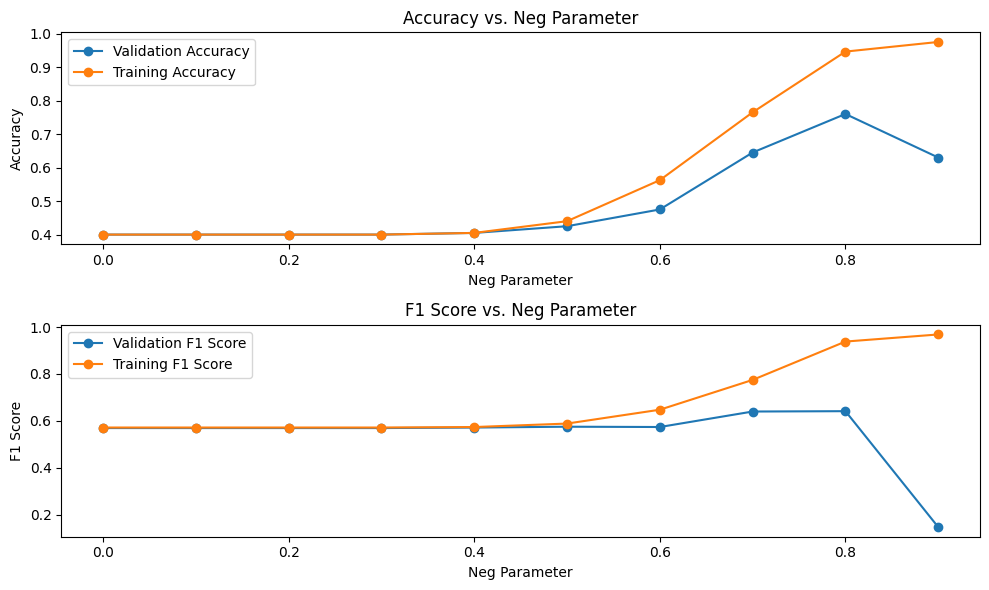

In [27]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Sample 200 examples stratified by the 'generated' column
df_sampled, _ = train_test_split(df_original, train_size=200, stratify=df["target"], random_state=42)

# Reset index for consistency
df = df_sampled.reset_index(drop=True)

# Define the range of values for the 'neg' parameter
neg_values = [i * 0.1 for i in range(10)]  # Values from 0 to 1

# Lists to store the results
val_acc_results = []
train_acc_results = []
val_f1_results = []
train_f1_results = []

# Variables to track the best 'neg' values
best_neg_val_acc = None
best_val_acc = -float('inf')

best_neg_f1 = None
best_f1_val = -float('inf')

# Setup KFold cross-validation
kf = KFold(n_splits=5, random_state=123, shuffle=True)

# Loop over the 'neg' parameter values and evaluate
for neg in neg_values:
    print(f"\nEvaluating for neg = {neg:.2f}")
    val_acc_fold = []
    train_acc_fold = []
    val_f1_fold = []
    train_f1_fold = []

    # Cross-validation
    for fold_idx, (train_index, test_index) in enumerate(kf.split(df)):
        print(f"  Fold {fold_idx + 1}")
        train_df = df.iloc[train_index]
        val_df = df.iloc[test_index]

        sia = SentimentIntensityAnalyzer()

        # Update lexicon
        dict_of_terms = dictionary_update(train_df, alpha=0.58, beta=0.05)
        sia.lexicon.update(dict_of_terms)

        # Evaluate
        val_acc, train_acc, pred_val, true_val, pred_train, true_train = evaluate(
            train_df, val_df, neg=neg, com=1, pos=0.65
        )

        f1_val = f1_score(true_val, pred_val)
        f1_train = f1_score(true_train, pred_train)

        print(f"    Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        print(f"    Train F1:  {f1_train:.4f}, Val F1:  {f1_val:.4f}")

        val_acc_fold.append(val_acc)
        train_acc_fold.append(train_acc)
        val_f1_fold.append(f1_val)
        train_f1_fold.append(f1_train)

    # Average results for this neg value
    avg_val_acc = sum(val_acc_fold) / len(val_acc_fold)
    avg_train_acc = sum(train_acc_fold) / len(train_acc_fold)
    avg_val_f1 = sum(val_f1_fold) / len(val_f1_fold)
    avg_train_f1 = sum(train_f1_fold) / len(train_f1_fold)

    print(f"  Avg Train Acc: {avg_train_acc:.4f}, Avg Val Acc: {avg_val_acc:.4f}")
    print(f"  Avg Train F1:  {avg_train_f1:.4f}, Avg Val F1:  {avg_val_f1:.4f}")

    val_acc_results.append(avg_val_acc)
    train_acc_results.append(avg_train_acc)
    val_f1_results.append(avg_val_f1)
    train_f1_results.append(avg_train_f1)

    # Update best scores
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        best_neg_val_acc = neg
        print(f"  --> New best validation accuracy: {best_val_acc:.4f} at neg={neg:.2f}")

    if avg_val_f1 > best_f1_val:
        best_f1_val = avg_val_f1
        best_neg_f1 = neg
        print(f"  --> New best validation F1 score: {best_f1_val:.4f} at neg={neg:.2f}")

# Summary of best parameters
print("\nBest neg for validation accuracy:", best_neg_val_acc, "with accuracy:", best_val_acc)
print("Best neg for validation F1 score:", best_neg_f1, "with F1 score:", best_f1_val)

# Plotting the results
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(neg_values, val_acc_results, label="Validation Accuracy", marker='o')
plt.plot(neg_values, train_acc_results, label="Training Accuracy", marker='o')
plt.xlabel('Neg Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Neg Parameter')
plt.legend()

# F1 score plot
plt.subplot(2, 1, 2)
plt.plot(neg_values, val_f1_results, label="Validation F1 Score", marker='o')
plt.plot(neg_values, train_f1_results, label="Training F1 Score", marker='o')
plt.xlabel('Neg Parameter')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Neg Parameter')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
# Output the best 'neg' values for validation accuracy and F1 score
print(f"Best 'neg' for validation accuracy: {best_neg_val_acc} with accuracy {best_val_acc}")
print(f"Best 'neg' for validation F1 score: {best_neg_f1} with F1 score {best_f1_val}")

Best 'neg' for validation accuracy: 0.8 with accuracy 0.76
Best 'neg' for validation F1 score: 0.8 with F1 score 0.641025641025641


Now, we can choose best pos value, with best value for neg.


Evaluating for pos = 0.00
  Fold 1
    Train Acc: 0.6062, Val Acc: 0.5750
    Train F1:  0.0000, Val F1:  0.0000
  Fold 2
    Train Acc: 0.5750, Val Acc: 0.7000
    Train F1:  0.0000, Val F1:  0.0000
  Fold 3
    Train Acc: 0.6125, Val Acc: 0.5500
    Train F1:  0.0000, Val F1:  0.0000
  Fold 4
    Train Acc: 0.5938, Val Acc: 0.6250
    Train F1:  0.0000, Val F1:  0.0000
  Fold 5
    Train Acc: 0.6125, Val Acc: 0.5500
    Train F1:  0.0000, Val F1:  0.0000
  Avg Train Acc: 0.6000, Avg Val Acc: 0.6000
  Avg Train F1:  0.0000, Avg Val F1:  0.0000
  --> New best validation accuracy: 0.6000 at pos=0.00
  --> New best validation F1 score: 0.0000 at pos=0.00

Evaluating for pos = 0.10
  Fold 1
    Train Acc: 0.9875, Val Acc: 0.7500
    Train F1:  0.9839, Val F1:  0.5833
  Fold 2
    Train Acc: 0.9875, Val Acc: 0.8500
    Train F1:  0.9853, Val F1:  0.7000
  Fold 3
    Train Acc: 0.9875, Val Acc: 0.7750
    Train F1:  0.9841, Val F1:  0.6667
  Fold 4
    Train Acc: 0.9938, Val Acc: 0.8250
  

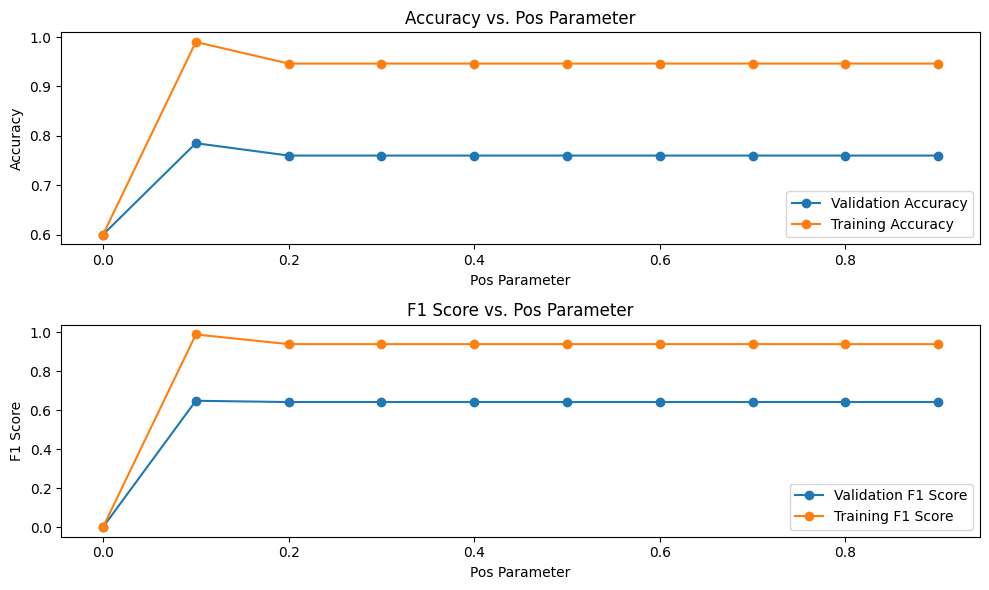

In [30]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Define the range of values for the 'pos' parameter
pos_values = [i * 0.1 for i in range(10)]  # 0.0 to 0.9

# Results storage
val_acc_results_pos = []
train_acc_results_pos = []
val_f1_results_pos = []
train_f1_results_pos = []

# Tracking best scores
best_pos_val_acc = None
best_val_acc_pos = -float('inf')
best_pos_f1 = None
best_f1_val_pos = -float('inf')

# KFold setup
kf = KFold(n_splits=5, random_state=123, shuffle=True)

# Evaluate for each 'pos' value
for pos in pos_values:
    print(f"\nEvaluating for pos = {pos:.2f}")
    val_acc_fold_pos = []
    train_acc_fold_pos = []
    val_f1_fold_pos = []
    train_f1_fold_pos = []

    for fold_idx, (train_index, test_index) in enumerate(kf.split(df)):
        print(f"  Fold {fold_idx + 1}")
        train_df = df.iloc[train_index]
        val_df = df.iloc[test_index]

        sia = SentimentIntensityAnalyzer()
        dict_of_terms = dictionary_update(train_df, alpha=0.58, beta=0.05)
        sia.lexicon.update(dict_of_terms)

        val_acc, train_acc, pred_val, true_val, pred_train, true_train = evaluate(
            train_df, val_df, neg=best_neg_f1, com=1, pos=pos
        )

        f1_val = f1_score(true_val, pred_val)
        f1_train = f1_score(true_train, pred_train)

        print(f"    Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        print(f"    Train F1:  {f1_train:.4f}, Val F1:  {f1_val:.4f}")

        val_acc_fold_pos.append(val_acc)
        train_acc_fold_pos.append(train_acc)
        val_f1_fold_pos.append(f1_val)
        train_f1_fold_pos.append(f1_train)

    # Averages for current pos
    avg_val_acc_pos = sum(val_acc_fold_pos) / len(val_acc_fold_pos)
    avg_train_acc_pos = sum(train_acc_fold_pos) / len(train_acc_fold_pos)
    avg_val_f1_pos = sum(val_f1_fold_pos) / len(val_f1_fold_pos)
    avg_train_f1_pos = sum(train_f1_fold_pos) / len(train_f1_fold_pos)

    print(f"  Avg Train Acc: {avg_train_acc_pos:.4f}, Avg Val Acc: {avg_val_acc_pos:.4f}")
    print(f"  Avg Train F1:  {avg_train_f1_pos:.4f}, Avg Val F1:  {avg_val_f1_pos:.4f}")

    # Save results
    val_acc_results_pos.append(avg_val_acc_pos)
    train_acc_results_pos.append(avg_train_acc_pos)
    val_f1_results_pos.append(avg_val_f1_pos)
    train_f1_results_pos.append(avg_train_f1_pos)

    if avg_val_acc_pos > best_val_acc_pos:
        best_val_acc_pos = avg_val_acc_pos
        best_pos_val_acc = pos
        print(f"  --> New best validation accuracy: {best_val_acc_pos:.4f} at pos={pos:.2f}")

    if avg_val_f1_pos > best_f1_val_pos:
        best_f1_val_pos = avg_val_f1_pos
        best_pos_f1 = pos
        print(f"  --> New best validation F1 score: {best_f1_val_pos:.4f} at pos={pos:.2f}")

# Summary
print("\nBest pos for validation accuracy:", best_pos_val_acc, "with accuracy:", best_val_acc_pos)
print("Best pos for validation F1 score:", best_pos_f1, "with F1 score:", best_f1_val_pos)

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(pos_values, val_acc_results_pos, label="Validation Accuracy", marker='o')
plt.plot(pos_values, train_acc_results_pos, label="Training Accuracy", marker='o')
plt.xlabel('Pos Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Pos Parameter')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(pos_values, val_f1_results_pos, label="Validation F1 Score", marker='o')
plt.plot(pos_values, train_f1_results_pos, label="Training F1 Score", marker='o')
plt.xlabel('Pos Parameter')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Pos Parameter')
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
# Output the best 'pos' values for validation accuracy and F1 score
print(f"Best 'pos' for validation accuracy: {best_pos_val_acc} with accuracy {best_val_acc_pos}")
print(f"Best 'pos' for validation F1 score: {best_pos_f1} with F1 score {best_f1_val_pos}")

Best 'pos' for validation accuracy: 0.1 with accuracy 0.785
Best 'pos' for validation F1 score: 0.1 with F1 score 0.6476489533011272


Let find best value also for com value, with best values fixed.


Evaluating for com = 0.00
  Fold 1
    Train Acc: 0.9875, Val Acc: 0.7500
    Train F1:  0.9839, Val F1:  0.5833
  Fold 2
    Train Acc: 0.9875, Val Acc: 0.8500
    Train F1:  0.9853, Val F1:  0.7000
  Fold 3
    Train Acc: 0.9875, Val Acc: 0.7750
    Train F1:  0.9841, Val F1:  0.6667
  Fold 4
    Train Acc: 0.9938, Val Acc: 0.8250
    Train F1:  0.9924, Val F1:  0.6957
  Fold 5
    Train Acc: 0.9938, Val Acc: 0.7250
    Train F1:  0.9920, Val F1:  0.5926
  Avg Train Acc: 0.9900, Avg Val Acc: 0.7850
  Avg Train F1:  0.9875, Avg Val F1:  0.6476
  --> New best validation accuracy: 0.7850 at com=0.00
  --> New best validation F1 score: 0.6476 at com=0.00

Evaluating for com = 0.10
  Fold 1
    Train Acc: 0.9875, Val Acc: 0.7500
    Train F1:  0.9839, Val F1:  0.5833
  Fold 2
    Train Acc: 0.9875, Val Acc: 0.8500
    Train F1:  0.9853, Val F1:  0.7000
  Fold 3
    Train Acc: 0.9875, Val Acc: 0.7750
    Train F1:  0.9841, Val F1:  0.6667
  Fold 4
    Train Acc: 0.9938, Val Acc: 0.8250
  

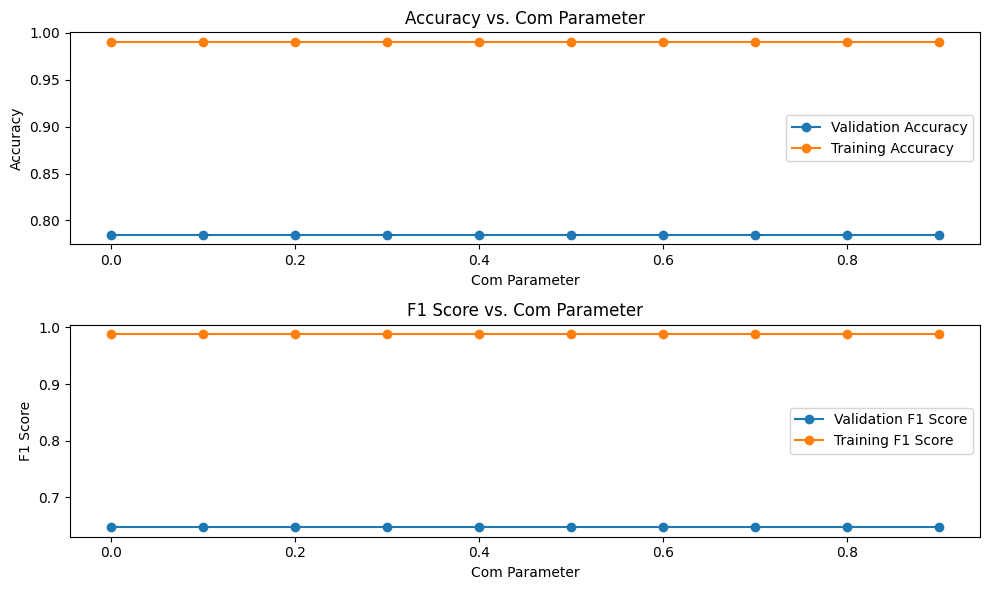

In [32]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Define the range of values for the 'com' parameter (e.g., from 0 to 1)
com_values = [i * 0.1 for i in range(10)]  # Values from 0.0 to 0.9

# Lists to store the results
val_acc_results_com = []
train_acc_results_com = []
val_f1_results_com = []
train_f1_results_com = []

# Variables to track the best 'com' values for accuracy and F1 score
best_com_val_acc = None
best_val_acc_com = -float('inf')
best_com_f1 = None
best_f1_val_com = -float('inf')

# Setup KFold cross-validation
kf = KFold(n_splits=5, random_state=123, shuffle=True)

# Loop over the 'com' parameter values and evaluate
for com in com_values:
    print(f"\nEvaluating for com = {com:.2f}")
    val_acc_fold_com = []
    train_acc_fold_com = []
    val_f1_fold_com = []
    train_f1_fold_com = []

    # Perform cross-validation
    for fold_idx, (train_index, test_index) in enumerate(kf.split(df)):
        print(f"  Fold {fold_idx + 1}")
        train_df = df.iloc[train_index]
        val_df = df.iloc[test_index]

        sia = SentimentIntensityAnalyzer()
        dict_of_terms = dictionary_update(train_df, alpha=0.58, beta=0.05)
        sia.lexicon.update(dict_of_terms)

        val_acc, train_acc, pred_val, true_val, pred_train, true_train = evaluate(
            train_df, val_df, neg=best_neg_f1, com=com, pos=best_pos_f1
        )

        f1_val = f1_score(true_val, pred_val)
        f1_train = f1_score(true_train, pred_train)

        print(f"    Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        print(f"    Train F1:  {f1_train:.4f}, Val F1:  {f1_val:.4f}")

        val_acc_fold_com.append(val_acc)
        train_acc_fold_com.append(train_acc)
        val_f1_fold_com.append(f1_val)
        train_f1_fold_com.append(f1_train)

    # Calculate average metrics for this 'com' value
    avg_val_acc_com = sum(val_acc_fold_com) / len(val_acc_fold_com)
    avg_train_acc_com = sum(train_acc_fold_com) / len(train_acc_fold_com)
    avg_val_f1_com = sum(val_f1_fold_com) / len(val_f1_fold_com)
    avg_train_f1_com = sum(train_f1_fold_com) / len(train_f1_fold_com)

    print(f"  Avg Train Acc: {avg_train_acc_com:.4f}, Avg Val Acc: {avg_val_acc_com:.4f}")
    print(f"  Avg Train F1:  {avg_train_f1_com:.4f}, Avg Val F1:  {avg_val_f1_com:.4f}")

    # Store the average results
    val_acc_results_com.append(avg_val_acc_com)
    train_acc_results_com.append(avg_train_acc_com)
    val_f1_results_com.append(avg_val_f1_com)
    train_f1_results_com.append(avg_train_f1_com)

    if avg_val_acc_com > best_val_acc_com:
        best_val_acc_com = avg_val_acc_com
        best_com_val_acc = com
        print(f"  --> New best validation accuracy: {best_val_acc_com:.4f} at com={com:.2f}")

    if avg_val_f1_com > best_f1_val_com:
        best_f1_val_com = avg_val_f1_com
        best_com_f1 = com
        print(f"  --> New best validation F1 score: {best_f1_val_com:.4f} at com={com:.2f}")

# Final summary
print("\nBest com for validation accuracy:", best_com_val_acc, "with accuracy:", best_val_acc_com)
print("Best com for validation F1 score:", best_com_f1, "with F1 score:", best_f1_val_com)

# Plotting the results for 'com' parameter
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.subplot(2, 1, 1)
plt.plot(com_values, val_acc_results_com, label="Validation Accuracy", marker='o')
plt.plot(com_values, train_acc_results_com, label="Training Accuracy", marker='o')
plt.xlabel('Com Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Com Parameter')
plt.legend()

# Plot F1 score
plt.subplot(2, 1, 2)
plt.plot(com_values, val_f1_results_com, label="Validation F1 Score", marker='o')
plt.plot(com_values, train_f1_results_com, label="Training F1 Score", marker='o')
plt.xlabel('Com Parameter')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Com Parameter')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
# Output the best 'com' values for validation accuracy and F1 score
print(f"Best 'com' for validation accuracy: {best_com_val_acc} with accuracy {best_val_acc_com}")
print(f"Best 'com' for validation F1 score: {best_com_f1} with F1 score {best_f1_val_com}")

Best 'com' for validation accuracy: 0.0 with accuracy 0.785
Best 'com' for validation F1 score: 0.0 with F1 score 0.6476489533011272
